### RLab06 - Martina Cacciola (2097476)

In [12]:
library(tidyverse)
library(ggplot2)
library(lubridate)
library(dplyr)
library(tidyr)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.1     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::extract() masks runjags::extract()
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Exercise  1

In [4]:
Sys.setenv(PATH = "C:\\Program Files\\JAGS\\JAGS-4.1.0\\x64\\bin")

In [5]:
Sys.setenv(JAGS_HOME="C:\\Program Files\\JAGS\\JAGS-4.1.0")

In [2]:
install.packages("rjags", type = "binary")
install.packages("runjags", type = "binary")


  C'è una versione binaria disponibile (e sarà installata) ma la
  versione dei sorgenti è successiva:
      binary source
rjags   4-13   4-14

package 'rjags' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\scumb\AppData\Local\Temp\Rtmpuo8oIH\downloaded_packages
package 'runjags' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\scumb\AppData\Local\Temp\Rtmpuo8oIH\downloaded_packages


In [6]:
library(rjags)
library(runjags)

Linked to JAGS 4.1.0

Loaded modules: basemod,bugs



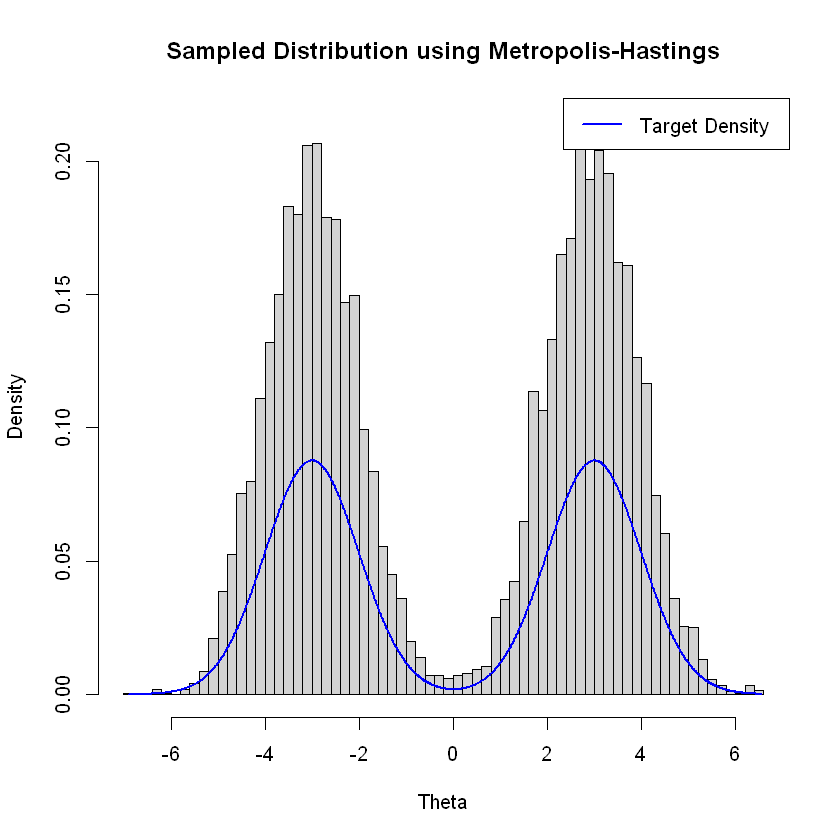

In [36]:
# Define the un-normalized posterior distribution
g <- function(theta) {
  return (0.5 * exp(-(theta + 3)^2 / 2) + 0.5 * exp(-(theta - 3)^2 / 2))
}

# Metropolis-Hastings algorithm
metropolis_hastings <- function(num_iterations, initial_theta) {
  theta_chain <- numeric(num_iterations + 1)
  theta_chain[1] <- initial_theta
  current_theta <- initial_theta
  
  for (i in 1:num_iterations) {
    # Generate candidate from proposal distribution (normal distribution)
    candidate_theta <- rnorm(1, current_theta, 1)
    
    # Calculate acceptance ratio
    acceptance_ratio <- min(1, g(candidate_theta) / g(current_theta))
    
    # Accept or reject candidate based on acceptance ratio
    if (runif(1) < acceptance_ratio) {
      current_theta <- candidate_theta
    }
    
    theta_chain[i + 1] <- current_theta
  }
  
  return (theta_chain)
}

# Set the number of iterations and initial value
num_iterations <- 10000
initial_theta <- 0

# Generate Markov Chain using Metropolis-Hastings algorithm
chain <- metropolis_hastings(num_iterations, initial_theta)

# Plot the sampled distribution
hist(chain, breaks = 50, freq = FALSE, main = "Sampled Distribution using Metropolis-Hastings",
     xlab = "Theta", ylab = "Density")

# Generate values for the x-axis to interpolate the target density
x_values <- seq(min(chain), max(chain), length.out = 1000)

# Calculate the target density values for the x-axis values
target_density_values <- g(x_values)

# Scale the target density values
scaled_target_density <- target_density_values * max(hist(chain, plot = FALSE)$density)

# Add the interpolated target density curve to the plot
lines(x_values, scaled_target_density, col = "blue", lwd = 2)

# Add a legend for the target density curve
legend("topright", legend = "Target Density", col = "blue", lwd = 2)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-6.4083 -3.2488 -2.1811 -0.8202  2.5051  5.6305 


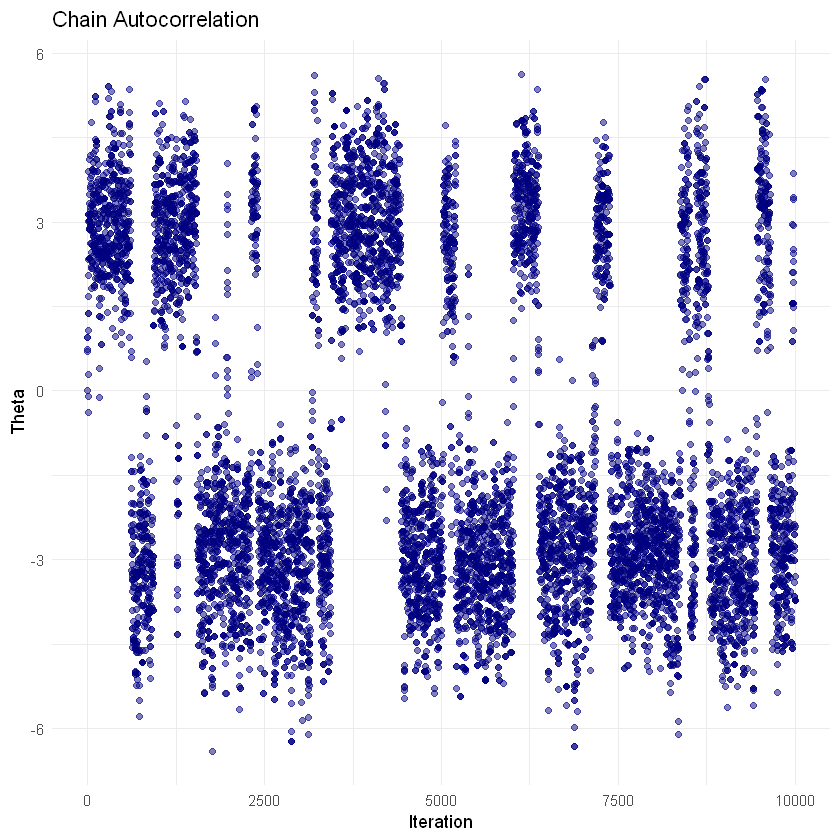

In [22]:
#Analyze the chain
print(summary(chain), col='navy')

#Format the chain
chain.df <- as.data.frame(as.mcmc(chain))

# Plot the correlation between theta and theta_chain
ggplot(data = chain.df, aes(x = 1:length(chain), y = chain)) +
  geom_point(color = 'navy', alpha = 0.5) +
  xlim(0, length(chain)) +
  labs(x = 'Iteration', y = 'Theta',
       title = 'Chain Autocorrelation') +
  theme_minimal()

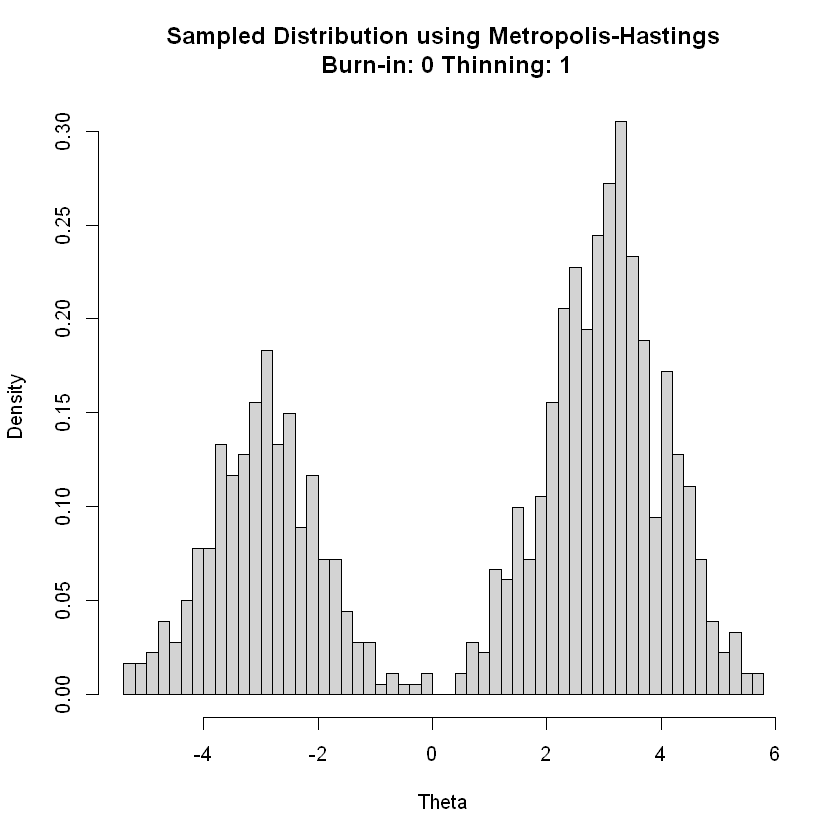

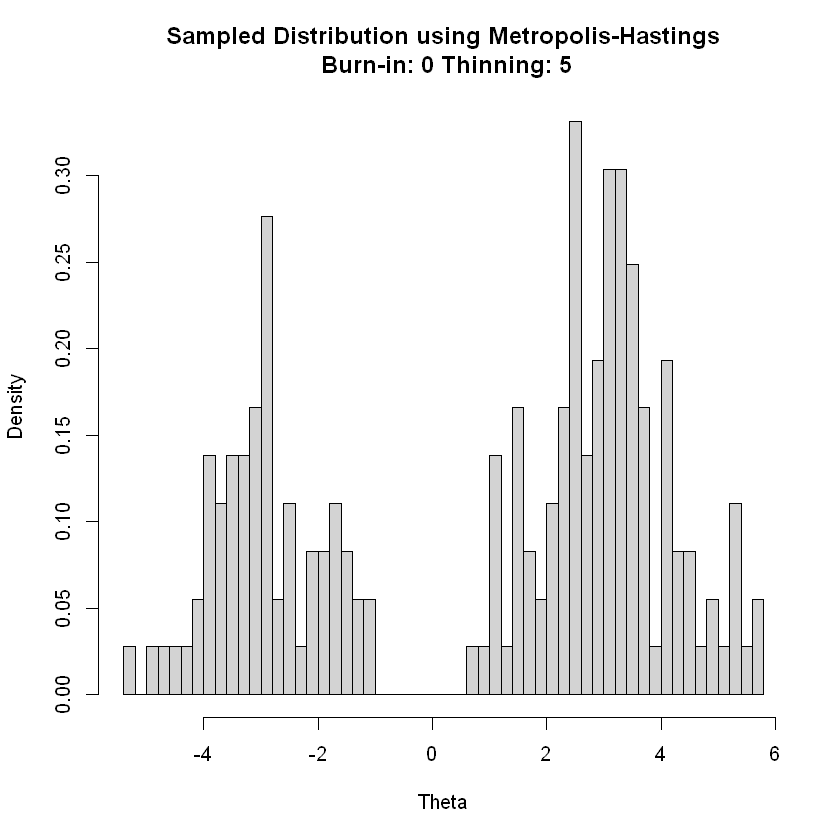

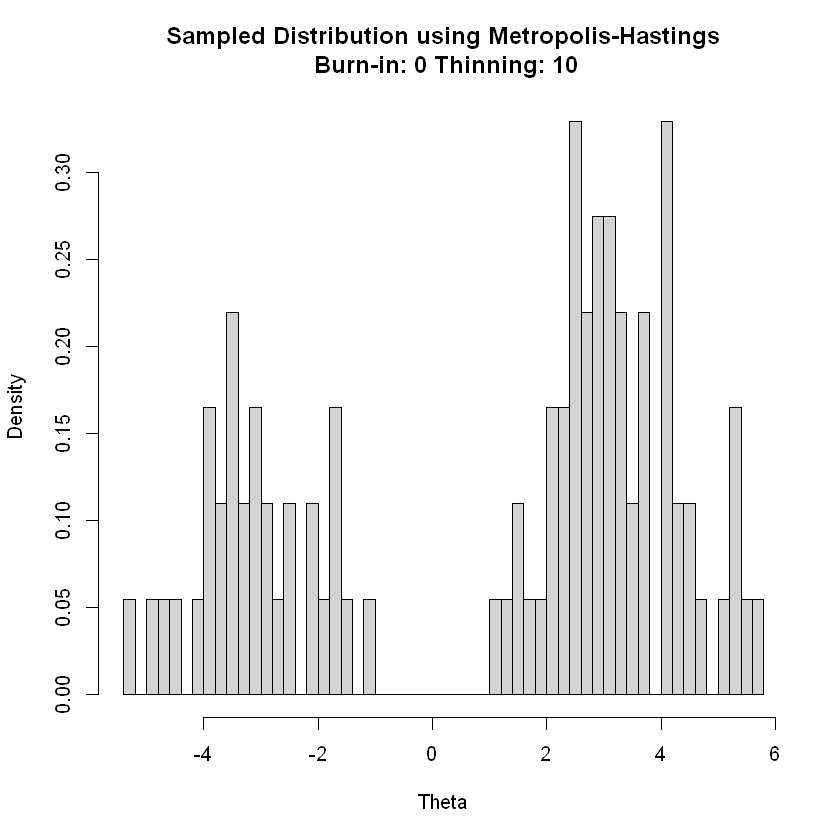

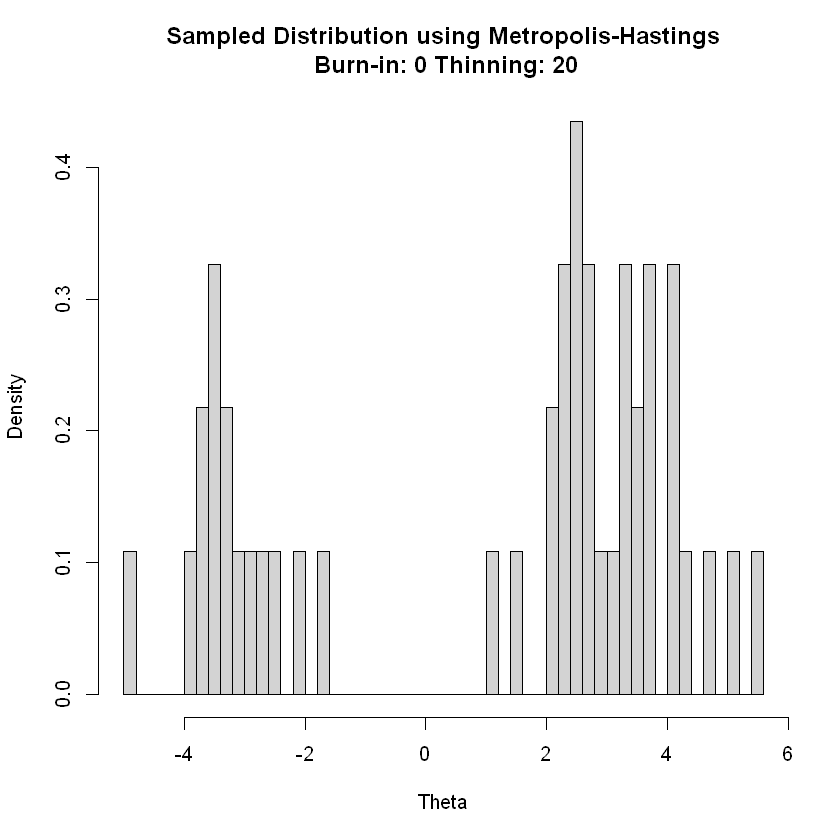

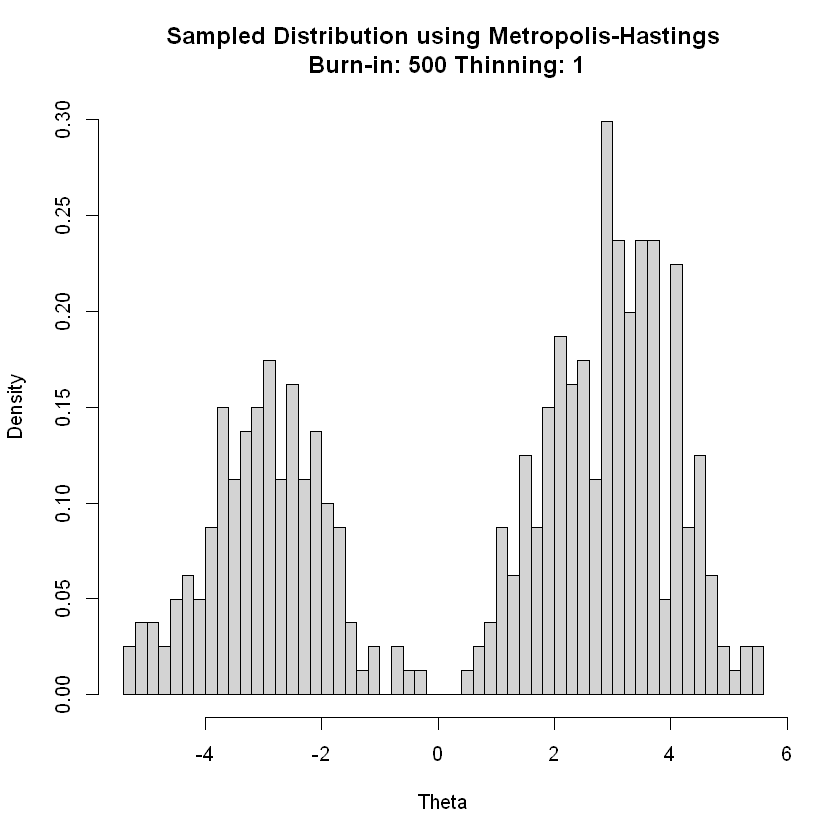

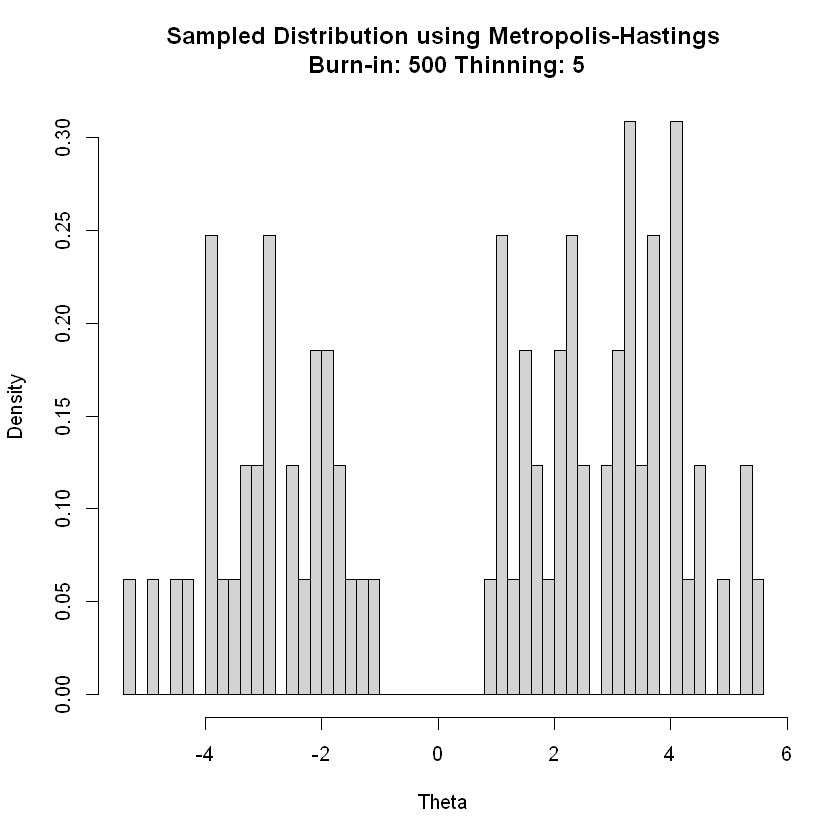

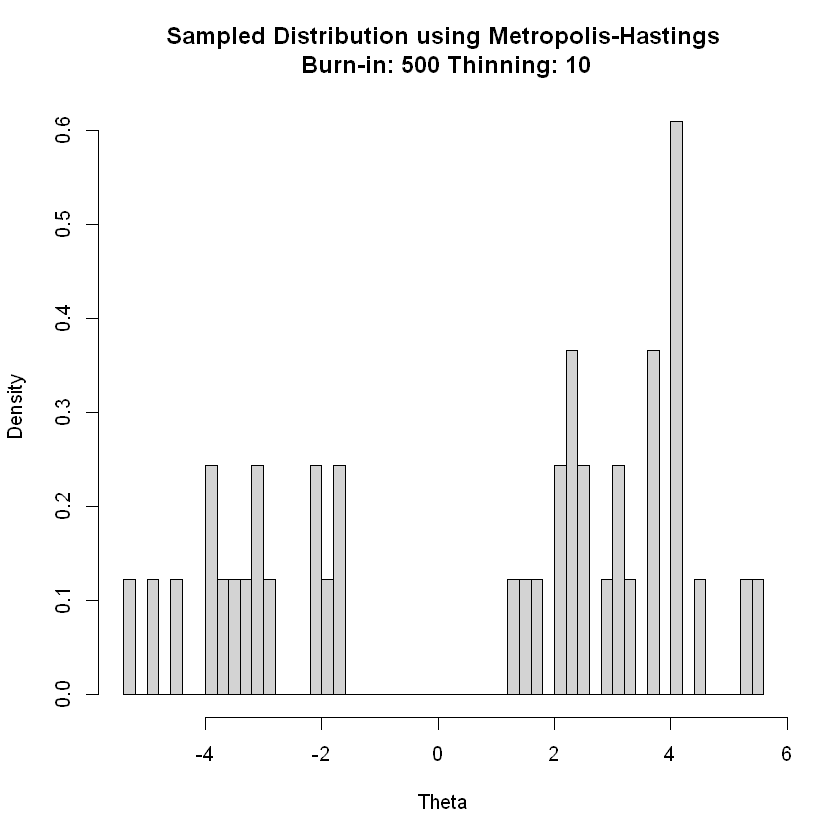

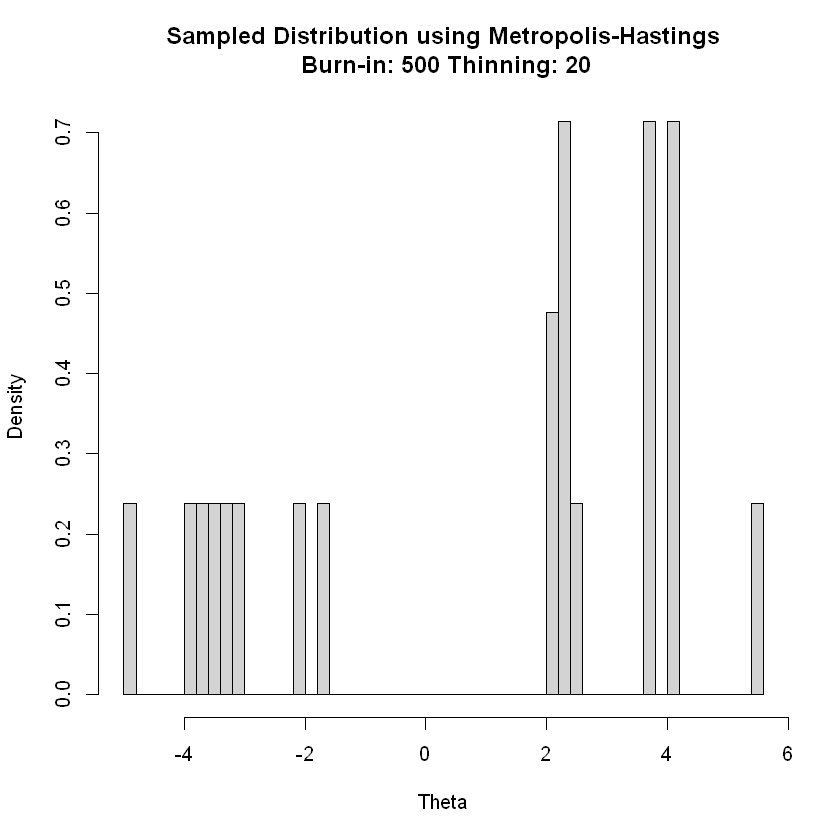

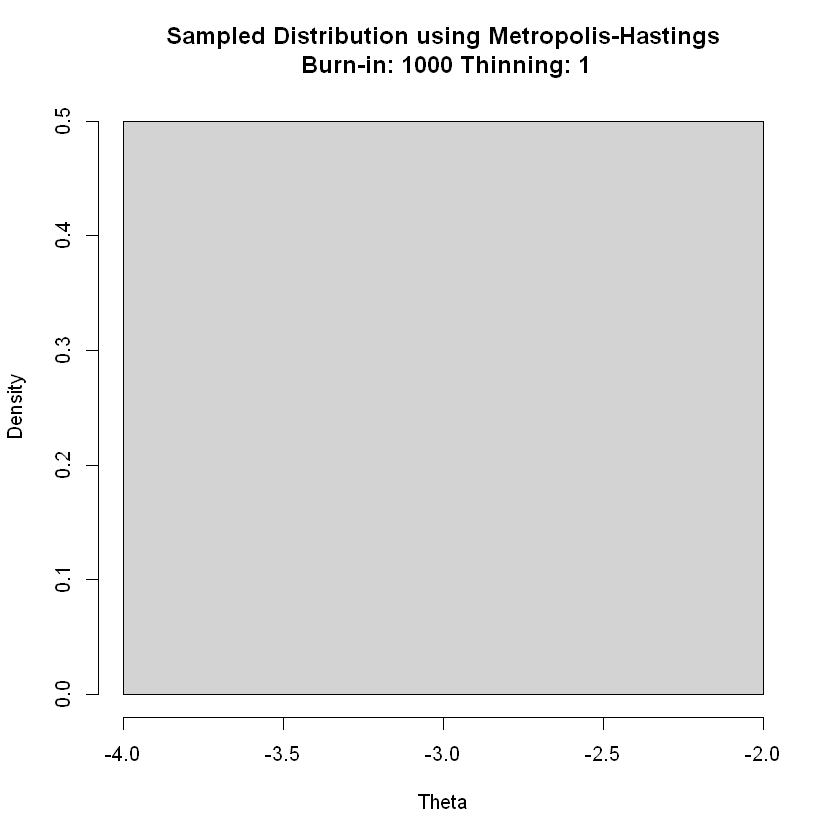

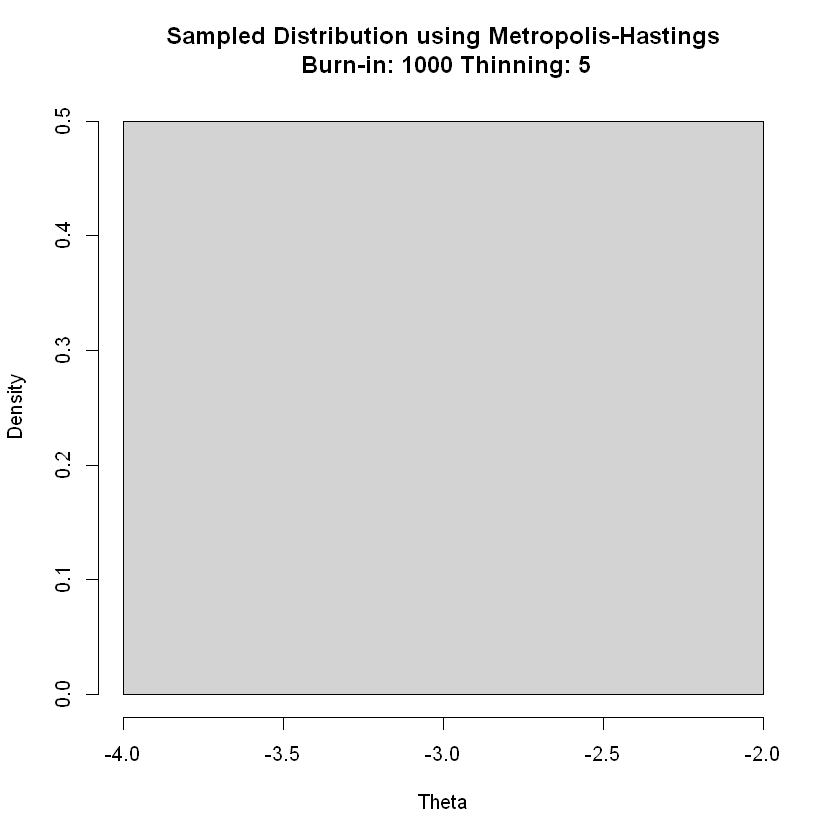

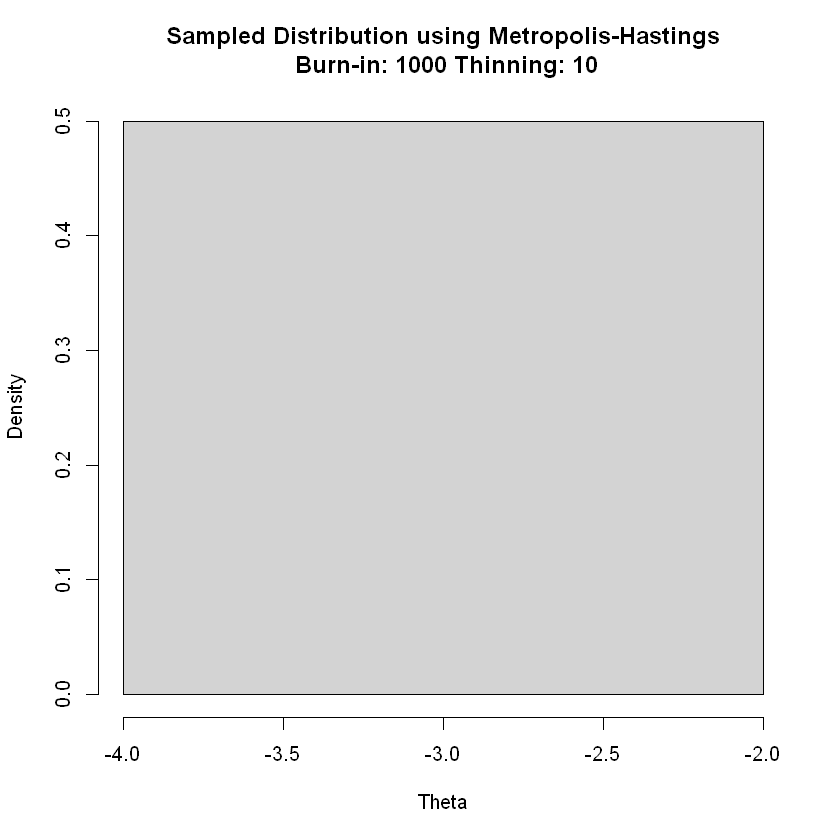

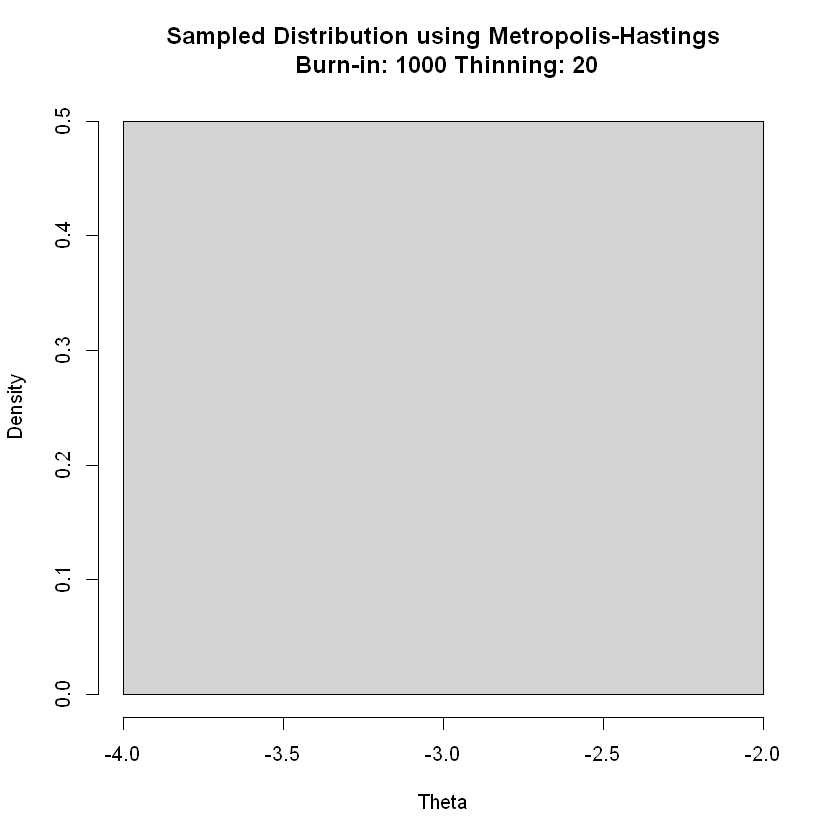

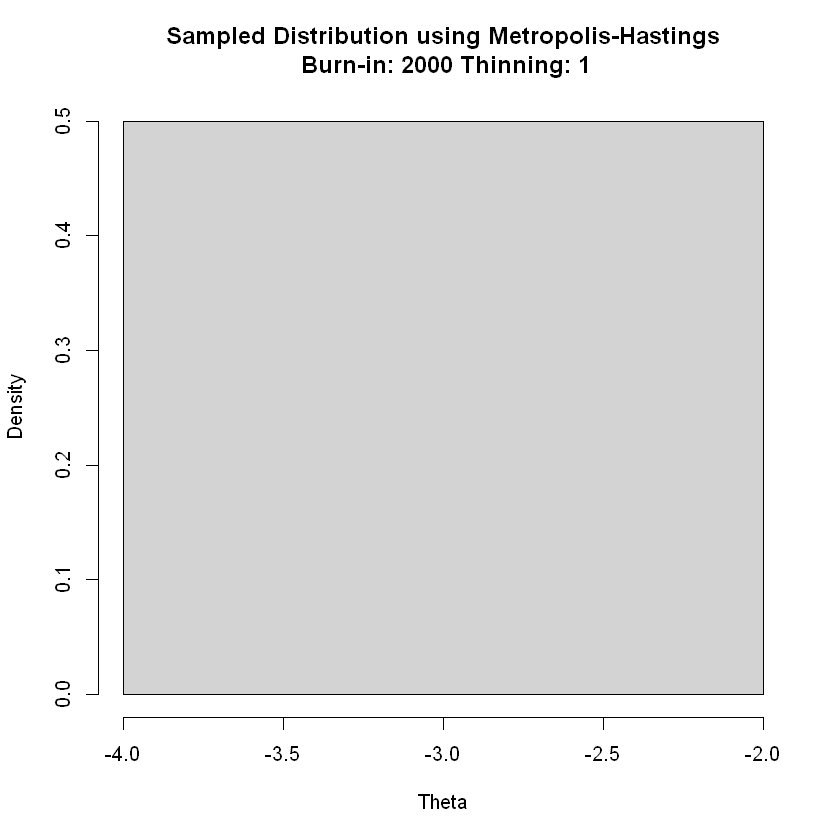

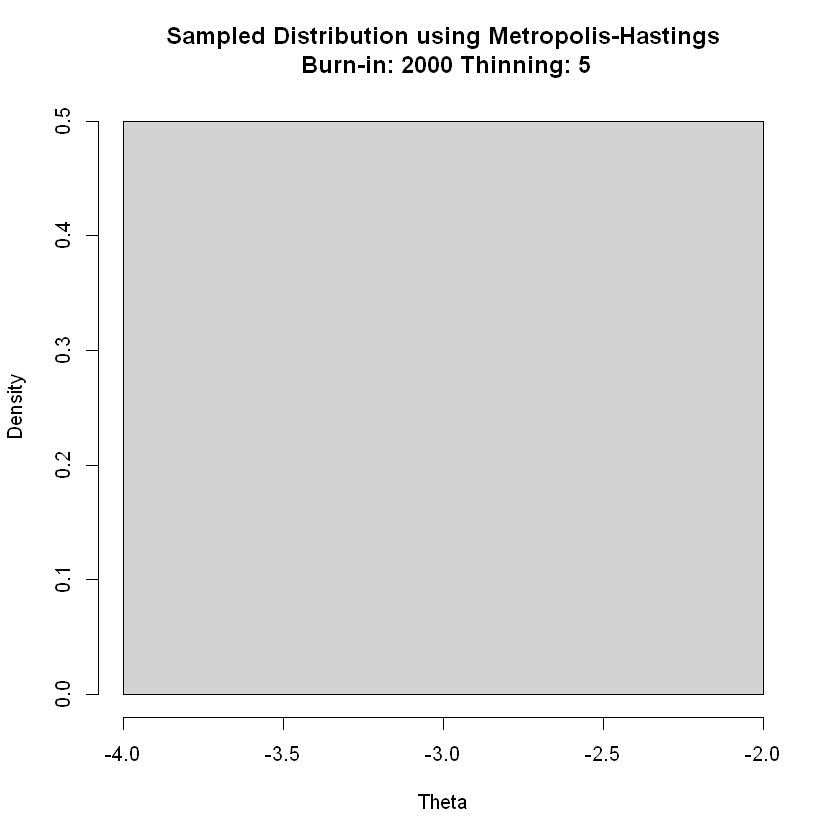

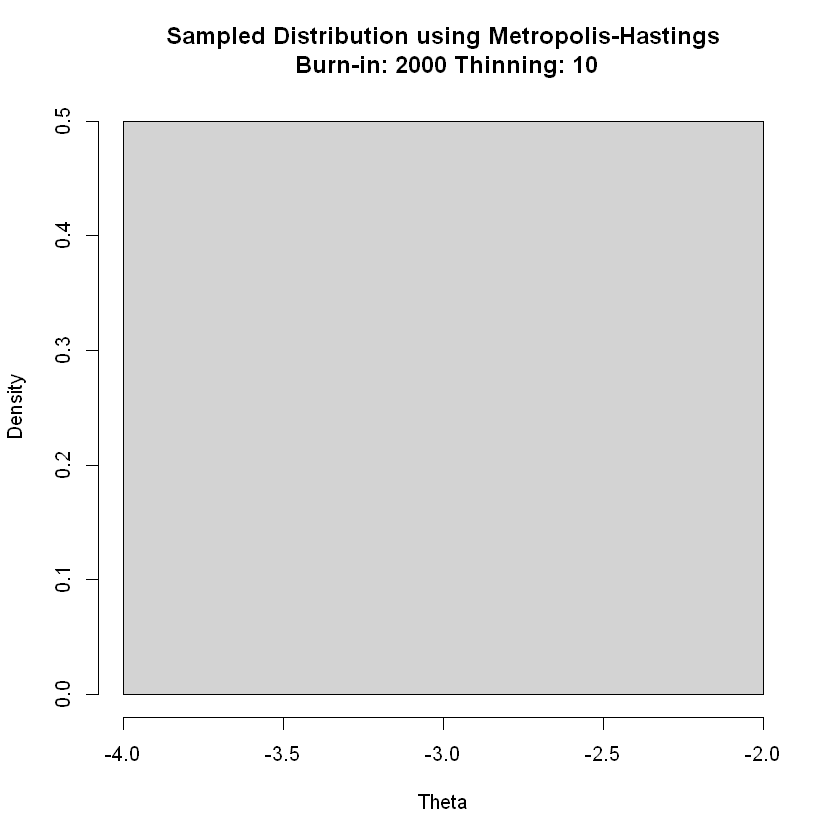

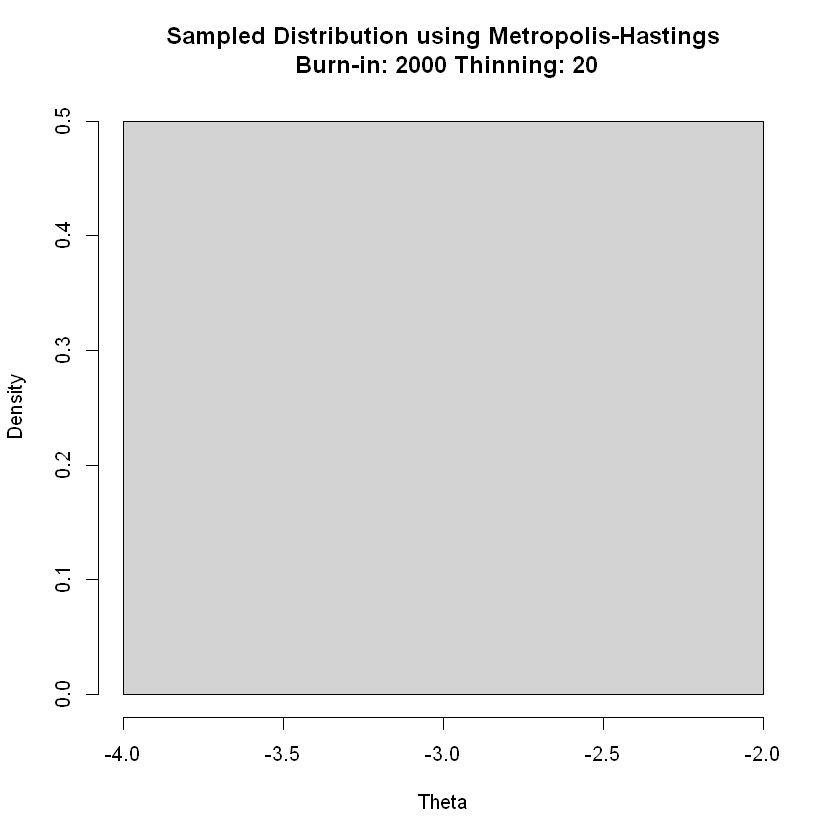

In [28]:
# Try different values of burn-in and thinning
burn_in_values <- c(0, 500, 1000, 2000)
thinning_values <- c(1, 5, 10, 20)

for (burn_in in burn_in_values) {
  for (thinning in thinning_values) {
    # Apply burn-in and thinning
    chain_burn_in_thin <- chain[(burn_in + 1):length(chain)]
    chain_burn_in_thin <- chain_burn_in_thin[seq(1, length(chain_burn_in_thin), by = thinning)]
    
    # Plot the sampled distribution
    hist(chain_burn_in_thin, breaks = 50, freq = FALSE,
         main = paste("Sampled Distribution using Metropolis-Hastings\n",
                      "Burn-in:", burn_in, "Thinning:", thinning),
         xlab = "Theta", ylab = "Density")
    
    # Plot the chain autocorrelation
    chain.df <- as.data.frame(as.mcmc(chain_burn_in_thin))
    ggplot(data = chain.df, aes(x = 1:length(chain_burn_in_thin), y = chain_burn_in_thin)) +
      geom_point(color = 'navy', alpha = 0.5) +
      xlim(0, length(chain_burn_in_thin)) +
      labs(x = 'Iteration', y = 'Theta',
          title = 'Chain Autocorrelation') +
      theme_minimal()
  }
}

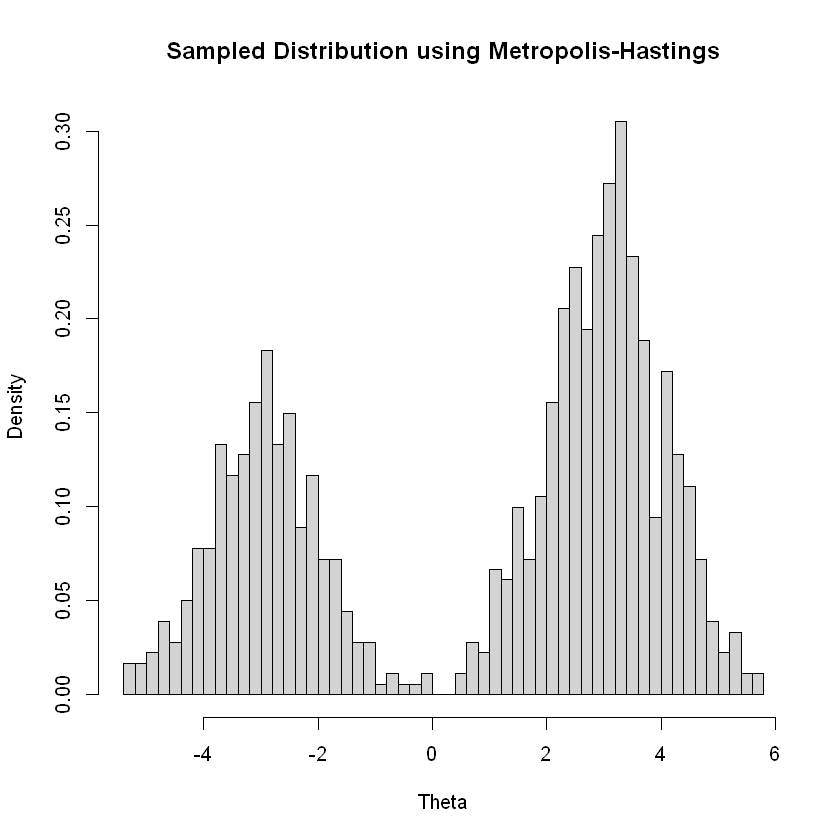

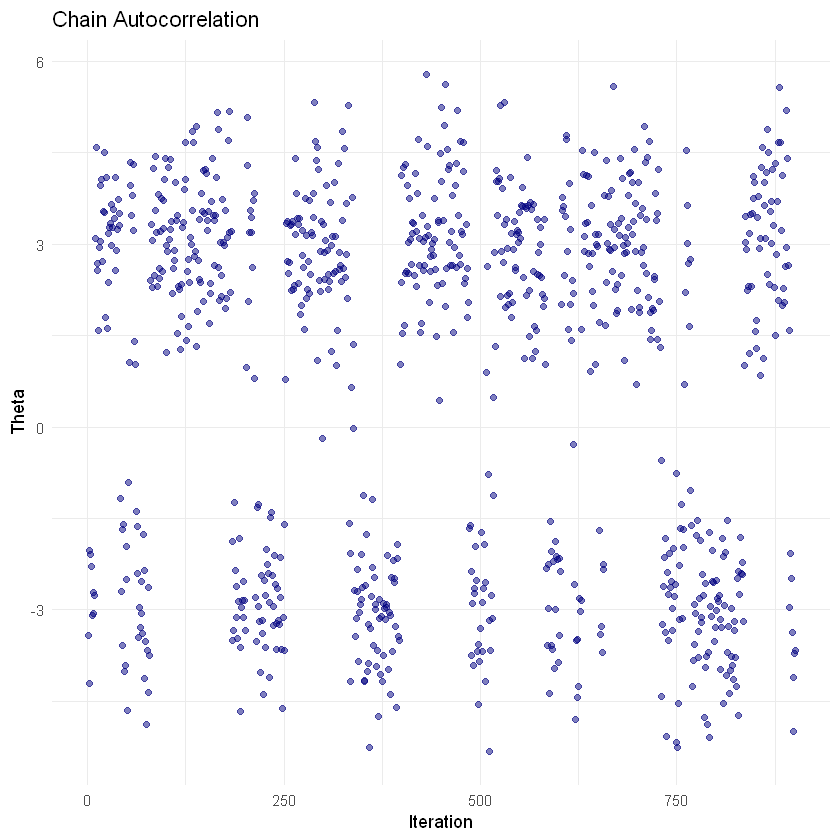

In [24]:
# Set the number of iterations, initial value, burn-in, and thinning
num_iterations <- 10000
initial_theta <- 0
burn_in <- 1000
thinning <- 10

# Generate Markov Chain using Metropolis-Hastings algorithm
chain <- metropolis_hastings(num_iterations, initial_theta)

# Apply burn-in and thinning
chain <- chain[(burn_in + 1):length(chain)]
chain <- chain[seq(1, length(chain), by = thinning)]

# Plot the sampled distribution
hist(chain, breaks = 50, freq = FALSE,
     main = "Sampled Distribution using Metropolis-Hastings",
     xlab = "Theta", ylab = "Density")

# Plot the chain autocorrelation
chain.df <- as.data.frame(as.mcmc(chain))
ggplot(data = chain.df, aes(x = 1:length(chain), y = chain)) +
  geom_point(color = 'navy', alpha = 0.5) +
  xlim(0, length(chain)) +
  labs(x = 'Iteration', y = 'Theta',
       title = 'Chain Autocorrelation') +
  theme_minimal()

# Exercise 3

In [9]:
# Read in data
data <- read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv")

# Filter for EU/EEA countries
eu_eea_countries <- c("Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Latvia", "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Norway", "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden")
data_eu_eea <- data %>% filter(location %in% eu_eea_countries & !is.na(daily_vaccinations))

# Calculate cumulative vaccinations
cumulative_vaccinations <- data_eu_eea %>%
  group_by(location) %>%
  mutate(cumulative_vaccinations = cumsum(daily_vaccinations)) %>%
  ungroup()

# Plot cumulative vaccinations
cumulative_vaccinations %>%
  na.omit() %>%
  ggplot(aes(x = date, y = cumulative_vaccinations, color = location)) +
  geom_line() +
  labs(title = "Cumulative vaccinations in EU/EEA countries",
       x = "Date",
       y = "Cumulative vaccinations")

# Calculate daily vaccinations
daily_vaccinations <- data_eu_eea %>%
  group_by(location) %>%
  mutate(daily_vaccinations = daily_vaccinations) %>%
  ungroup()

# Plot daily vaccinations
daily_vaccinations %>%
  ggplot(aes(x = date, y = daily_vaccinations, color = location)) +
  geom_line() +
  labs(title = "Daily vaccinations in EU/EEA countries",
       x = "Date",
       y = "Daily vaccinations")

# Calculate weekly average vaccinations
weekly_avg_vaccinations <- data_eu_eea %>%
  group_by(location, week = floor_date(date, unit = "week")) %>%
  summarize(weekly_avg_vaccinations = mean(daily_vaccinations)) %>%
  ungroup()

# Plot weekly average vaccinations
weekly_avg_vaccinations %>%
  ggplot(aes(x = week, y = weekly_avg_vaccinations, color = location)) +
  geom_line() +
  labs(title = "Weekly average vaccinations in EU/EEA countries",
       x = "Week",
       y = "Weekly average vaccinations")

# Read in deaths data
deaths_data <- read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

# Filter for EU/EEA countries
deaths_data_eu_eea <- deaths_data %>% filter(location %in% eu_eea_countries)

# Calculate cumulative deaths
cumulative_deaths <- deaths_data_eu_eea %>%
  group_by(location) %>%
  mutate(cumulative_deaths = cumsum(new_deaths)) %>%
  ungroup()

# Plot cumulative deaths
cumulative_deaths %>%
  ggplot(aes(x = date, y = cumulative_deaths, color = location)) +
  geom_line() +
  labs(title = "Cumulative COVID-19 deaths in EU/EEA countries",
       x = "Date",
       y = "Cumulative deaths")

# Calculate weekly average deaths
weekly_avg_deaths <- deaths_data_eu_eea %>%
  group_by(location, week = floor_date(date, unit = "week")) %>%
  summarize(weekly_avg_deaths = mean(new_deaths)) %>%
  ungroup()

# Plot weekly average deaths
weekly_avg_deaths %>%
  ggplot(aes(x = week, y = weekly_avg_deaths, color = location)) +
  geom_line() +
  labs(title = "Weekly average COVID-19 deaths in EU/EEA countries",
       x = "Week",
       y = "Weekly average deaths")

ERROR: Error in read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv"): non trovo la funzione "read_csv"


In [ ]:
# Check for missing values
sum(is.na(cumulative_vaccinations$cumulative_vaccinations))

[1] 23875